# Psychometric Curve (Behavior Data)

In [22]:
import numpy as np
import pandas as pd
import os, requests

import matplotlib.cm as cm
colormap = cm.viridis

# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Load Data
from functions import load_names # a function to get the file names

from functions import hide_toggle
hide_toggle()

### This one below takes some time:

In [4]:
# This part takes time
fname = [] # initialize the list
fname = load_names()
print(fname)

# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']


In [5]:
from functions import load_data

In [6]:
def get_task_difference(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session, alldat)

    dt = dat['bin_size']                  # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']         # contrast left
    r_cont = dat['contrast_right']        # contrast right
    
    cont_diff = r_cont - l_cont              # contrast difference: right if positive, left if negative
    abs_task_diff = np.abs(r_cont - l_cont)  # absolute contrast difference
    dtask_diff = np.diff(abs_task_diff)      # change in contrast difference (current - previous)
    dtdiff = np.insert(dtask_diff, 0, 0)     # adjust the array size

    return dt, NT, cont_diff, abs_task_diff, dtask_diff, dtdiff

# dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(1)

### Plot contrast difference and responses

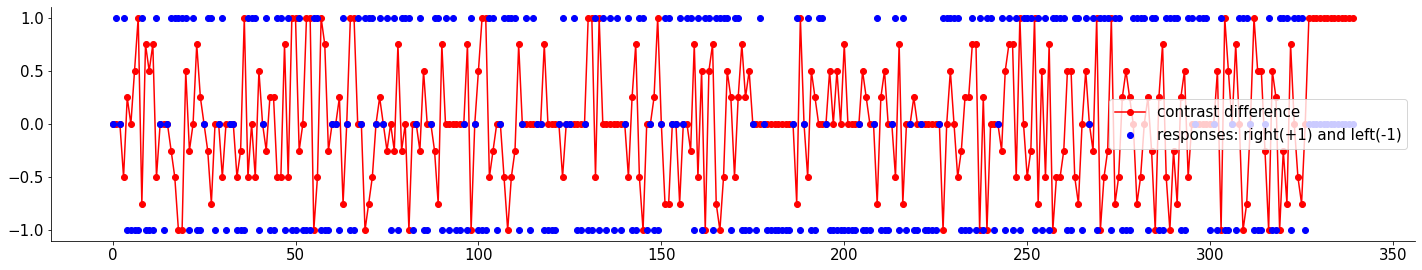

In [7]:
n_session = 11
dat, barea, NN, regions, brain_groups, nareas = load_data(n_session, alldat)

_, _, cont_diff, _, _, _ = get_task_difference(n_session)
plt.plot(cont_diff,'ro-', label='contrast difference')
plt.plot(dat['response'],'bo', label='responses: right(+1) and left(-1)')
plt.legend()
plt.show()

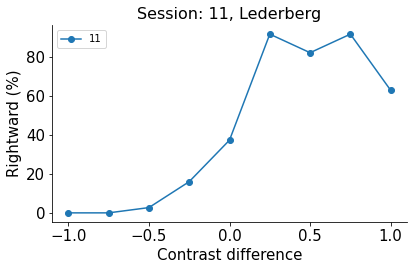

In [23]:
from functions import get_rightward # Get the % of rightward choice

# n_session=11
dat, _, _, _, _, _ = load_data(n_session, alldat)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)

# ===== function =====
# rightward = np.zeros(len(np.unique(cont_diff)))
# unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

# for i, val in enumerate(np.unique(cont_diff)):
#     resp = dat['response'][cont_diff==val]
#     rightward[i] = np.count_nonzero(resp<0) / counts[i]*100
# ====================
rightward = get_rightward(dat, cont_diff)

xdata = np.unique(cont_diff)
ydata = rightward

fig = plt.figure(figsize=(6,4))

plt.plot(xdata, ydata,'o-', label=n_session)
plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'], fontsize=16)
plt.legend(loc='upper left', fontsize=10)
plt.show()

### History Dependence (Previous choice & different task difficulties)

In [9]:
unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

print('Contrast difference and no. of trials:')
for i,val in enumerate(unique): print(val, ':', counts[i])
# print(dict(zip(unique, counts)))

keys = ['easy_r', 'hard_r', 'zero_r', 'easy_l', 'hard_l', 'zero_l']
vals = np.empty([6,9])
vals[:] = np.nan

right_levels = dict(zip(keys,vals))

Contrast difference and no. of trials:
-1.0 : 21
-0.75 : 20
-0.5 : 37
-0.25 : 25
0.0 : 126
0.25 : 24
0.5 : 28
0.75 : 24
1.0 : 35


In [10]:
response=dat['response'] # all 340 responses 

# Indices of right/left choice
idx_choice_r = np.array([i for i, x in enumerate(response<0) if x]) # trial number of right choice
idx_choice_l = np.array([i for i, x in enumerate(response>=0) if x]) # trial number of left choice

# Task difficulty of the right/left choice
level_r = abs(cont_diff[idx_choice_r]) # contrast difficulty (abs of contrast difference) of right choice trials 
level_l = abs(cont_diff[idx_choice_r]) # contrast difficulty (abs of contrast difference) of left choice trials 

In [11]:
# idx_choice_r.shape # check the number of right-choice trials

In [12]:
# --*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
# Make a list of arrays to store indices of right/left choice for each difficulty
# --*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--

'''
Description of the list (idx_RL[int])
    int = 
        0: easy r
        1: hard r
        2: zero r
        3: easy l
        4: hard l
        5: zero l
'''

idx_RL = [[np.empty(0, int)]*1]*6 # List of empty integer arrays

# Assign indices of the right choices for each difficulty
for i, idx in enumerate(idx_choice_r):
    if idx == (len(response)-1): continue # Discard the last trial
        
    if ((abs(cont_diff[idx]) == 1) | (abs(cont_diff[idx]) == 0.75)): # easy trials
        idx_RL[0] = np.append(idx_RL[0], idx)
    elif ((abs(cont_diff[idx]) == 0.25) | (abs(cont_diff[idx]) == 0.5)): # hard trials
        idx_RL[1] = np.append(idx_RL[1], idx)
    elif (abs(cont_diff[idx]) == 0): # zero trials
        idx_RL[2] = np.append(idx_RL[2], idx)

# Assign indices of the left choices for each difficulty
for i, idx in enumerate(idx_choice_l):
    if idx == (len(response)-1): continue # Discard the last trial
    
    if ((abs(cont_diff[idx]) == 1) | (abs(cont_diff[idx]) == 0.75)): # easy trials
        idx_RL[3] = np.append(idx_RL[3], idx)
    elif ((abs(cont_diff[idx]) == 0.25) | (abs(cont_diff[idx]) == 0.5)): # hard trials
        idx_RL[4] = np.append(idx_RL[4], idx)
    elif (abs(cont_diff[idx]) == 0): # zero trials
        idx_RL[5] = np.append(idx_RL[5], idx)

In [13]:
idx_RL[3]

array([  8,  18,  19,  27,  55,  63,  69,  70,  81,  89,  98, 108, 145,
       151, 152, 155, 162, 165, 166, 187, 209, 216, 227, 235, 237, 239,
       245, 253, 257, 264, 270, 274, 280, 285, 289, 291, 303, 309, 310,
       316, 319, 321, 325, 327, 328, 329, 330, 331, 332, 333, 334, 335,
       336, 337, 338])

In [14]:
print(keys)

for j in range(6):
    unique, counts = np.unique(cont_diff[idx_RL[j]+1], return_counts=True) # check the contrast differences and the number of occurences

    print('unique cont_diff size:', np.unique(cont_diff[idx_RL[j]+1]).size, keys[j])
    for i, val in enumerate(np.unique(cont_diff[idx_RL[j]+1])): # Assumption: cont_diff[...] has all the 9 contrast differences.
    #     print(i,':', val)
        resp = dat['response'][idx_RL[j]+1][cont_diff[idx_RL[j]+1]==val]
        array_indx = (4*val + 4).astype(int) # convert contrast difference value to the corresponding array index
        right_levels[keys[j]][array_indx] = np.count_nonzero(resp<0) / counts[i]*100 # right choice: i = -1

['easy_r', 'hard_r', 'zero_r', 'easy_l', 'hard_l', 'zero_l']
unique cont_diff size: 9 easy_r
unique cont_diff size: 9 hard_r
unique cont_diff size: 5 zero_r
unique cont_diff size: 9 easy_l
unique cont_diff size: 9 hard_l
unique cont_diff size: 9 zero_l


In [15]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

In [16]:
idx_RL[0].size

44

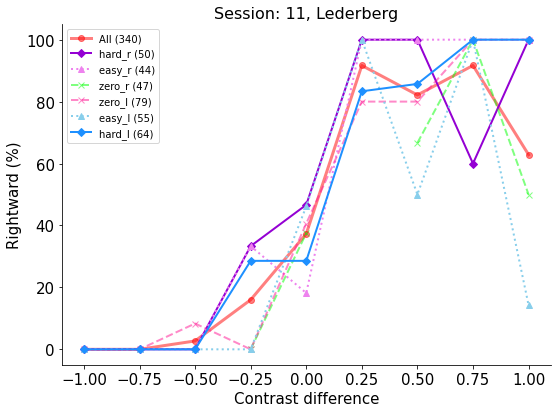

In [17]:
xdata = np.unique(cont_diff)
ydata = rightward

fig = plt.figure(figsize=(8,6))

plt.plot(xdata, ydata,'ro-', label='All (%1.0f)'%len(response), alpha=0.5, linewidth=3)

plt.plot(xdata, right_levels['hard_r'],'D-',  color=colors['darkviolet'], 
         label='hard_r (%1.0f)'%(idx_RL[1].size), linewidth=2)
plt.plot(xdata, right_levels['easy_r'],'^:',  color=colors['violet'], 
         label='easy_r (%1.0f)'%(idx_RL[0].size), linewidth=2)
plt.plot(xdata, right_levels['zero_r'],'x--', color=colors['lime'], 
         label='zero_r (%1.0f)'%(idx_RL[2].size), linewidth=2, alpha=0.5)
plt.plot(xdata, right_levels['zero_l'],'x--', color=colors['deeppink'], 
         label='zero_l (%1.0f)'%(idx_RL[5].size), linewidth=2, alpha=0.5)
plt.plot(xdata, right_levels['easy_l'],'^:',  color=colors['skyblue'], 
         label='easy_l (%1.0f)'%(idx_RL[3].size), linewidth=2)
plt.plot(xdata, right_levels['hard_l'],'D-',  color=colors['dodgerblue'], 
         label='hard_l (%1.0f)'%(idx_RL[4].size), linewidth=2)

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'], fontsize=16)
plt.legend(loc='upper left', fontsize=10)
plt.show()
hide_toggle()

## Checking

In [18]:
print('zero_l: ', right_levels['zero_l'])
print('zero_r:', right_levels['zero_r'])

zero_l:  [  0.           0.           8.33333333   0.          40.625
  80.          80.         100.         100.        ]
zero_r: [         nan          nan          nan   0.          37.5
          nan  66.66666667 100.          50.        ]


In [19]:
# Check the keys and values 
for key, value in right_levels.items():
    print(key,':', value)

easy_r : [  0.           0.           0.          33.33333333  18.18181818
 100.         100.         100.         100.        ]
hard_r : [  0.           0.           0.          33.33333333  46.66666667
 100.         100.          60.         100.        ]
zero_r : [         nan          nan          nan   0.          37.5
          nan  66.66666667 100.          50.        ]
easy_l : [  0.           0.           0.           0.          46.15384615
 100.          50.         100.          14.28571429]
hard_l : [  0.           0.           0.          28.57142857  28.57142857
  83.33333333  85.71428571 100.         100.        ]
zero_l : [  0.           0.           8.33333333   0.          40.625
  80.          80.         100.         100.        ]


In [20]:
# For Checking

j=5
unique, counts = np.unique(cont_diff[idx_RL[j]+1], return_counts=True) # check the contrast differences and the number of occurences
print('unique cont_diff size:', np.unique(cont_diff[idx_RL[j]+1]).size, keys[j])

for i, val in enumerate(np.unique(cont_diff[idx_RL[j]+1])): # Assumption: cont_diff[...] has all the 9 contrast differences.
        print(i,':', val)
        resp = dat['response'][idx_RL[j]+1][cont_diff[idx_RL[j]+1]==val]
        
        array_indx = (4*val + 4).astype(int) # convert contrast difference value to the corresponding array index
        right_levels[keys[j]][array_indx] = np.count_nonzero(resp>0) / counts[i]*100 # right choice: i = -1
        
print(np.unique(cont_diff[idx_RL[j]+1]))
print(right_levels[keys[j]])

unique cont_diff size: 9 zero_l
0 : -1.0
1 : -0.75
2 : -0.5
3 : -0.25
4 : 0.0
5 : 0.25
6 : 0.5
7 : 0.75
8 : 1.0
[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
[100.         100.          91.66666667 100.          25.
  20.          20.           0.           0.        ]
